In [2]:
import os
import numpy as np
import pandas as pd
from datetime import date

DATA_ROOT = "./data/"
df_train = pd.read_csv(os.path.join(DATA_ROOT,'train_offline.csv'))
df_test = pd.read_csv(os.path.join(DATA_ROOT,'test_offline.csv'))
print(df_train.shape)
print(df_test.shape)
df_train.head()

(1160742, 7)
(594142, 6)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN


In [3]:
df_train.dtypes

User_id            int64
Merchant_id        int64
Coupon_id        float64
Discount_rate     object
Distance         float64
Date_received    float64
Date             float64
dtype: object

In [ ]:
def use_days(row):
    if np.isnan(row['Date_received']):
        return -1
    if not np.isnan(row['Date']):
        td = pd.to_datetime(row['Date'], format='%Y%m%d') -  pd.to_datetime(row['Date_received'], format='%Y%m%d')
        if td <= pd.Timedelta(15, 'D'):
            return 1
    return 0

In [4]:
df_train['Date_received'] = pd.to_datetime(df_train['Date_received'], format='%Y%m%d')
df_train['Date'] = pd.to_datetime(df_train['Date'], format='%Y%m%d')
df_test['Date_received'] = pd.to_datetime(df_test['Date_received'], format='%Y%m%d')

In [64]:
df_train['use_days'] = (df_train.Date-df_train.Date_received).astype('timedelta64[D]')
df_train[['use_days']] = df_train[['use_days']].fillna(-1)

In [65]:
df_train.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,use_days
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17,-1.0
1,1439408,2632,8591.0,20:1,0.0,2016-02-17,NaT,-1.0
2,1439408,2632,1078.0,20:1,0.0,2016-03-19,NaT,-1.0
3,1832624,3381,7610.0,200:20,0.0,2016-04-29,NaT,-1.0
4,2029232,3381,11951.0,200:20,1.0,2016-01-29,NaT,-1.0


In [66]:
df_test.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received
0,1439408,4663,11002.0,150:20,1.0,2016-05-28
1,1439408,2632,8591.0,20:1,0.0,2016-06-13
2,1439408,2632,NaN,NaN,0.0,NaT
3,1439408,2632,8591.0,20:1,0.0,2016-05-16
4,2029232,450,1532.0,30:5,0.0,2016-05-30


In [67]:
# 取得用戶list
train_user = df_train.User_id.unique()
test_user = df_test.User_id.unique()

In [68]:
print(train_user.size)
print(test_user.size)

433113
237090


In [69]:
# 在訓練集跟測試集都有出現的用戶
all_user = list(set(train_user).intersection(set(test_user)))
print(len(all_user))

130765


In [70]:
print(df_train.Date_received.min())
print(df_train.Date_received.max())

2016-01-01 00:00:00
2016-04-30 00:00:00


In [109]:
print(df_train.Date.min())
print(df_train.Date.max())

2016-01-01 00:00:00
2016-06-28 00:00:00


In [71]:
print(df_test.Date_received.min())
print(df_test.Date_received.max())

2016-05-01 00:00:00
2016-06-15 00:00:00


In [72]:
coupon_cnt = df_train.groupby('Date_received')['User_id'].count().to_frame().reset_index()
coupon_cnt.User_id.describe()

count      121.000000
mean      6173.297521
std      11295.551942
min        536.000000
25%        840.000000
50%       2715.000000
75%       4965.000000
max      71658.000000
Name: User_id, dtype: float64

In [73]:
coupon_cnt = df_test.groupby('Date_received')['User_id'].count().to_frame().reset_index()
coupon_cnt.User_id.describe()

count       46.000000
mean      6658.978261
std       3774.180667
min       1885.000000
25%       3940.500000
50%       5666.500000
75%       7845.000000
max      19859.000000
Name: User_id, dtype: float64

In [74]:
# 用戶直接消費
train_purch = df_train[pd.isnull(df_train.Date_received)]
test_purch = df_test[pd.isnull(df_test.Date_received)]

In [75]:
# raw data size: (1160742, 7) (594142, 6)
print(train_purch.shape)
print(test_purch.shape)

(413773, 8)
(287829, 6)


In [76]:
# 用戶取得優惠卷
train_received = df_train[pd.notnull(df_train.Date_received)]
test_received = df_test[pd.notnull(df_test.Date_received)]

In [77]:
print(train_received.shape)
print(test_received.shape)

(746969, 8)
(306313, 6)


In [112]:
# 建立label標籤
def label(row):
    if row['use_days'] < 0:
        return 0
    elif row['use_days'] < 16:
        return 1
    else:
        return 2
train_received["label"] = train_received.apply(label, axis=1)
train_received["label"].value_counts()

D:\Anacoda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


0    704033
1     36304
2      6632
Name: label, dtype: int64

In [111]:
# 查看coupon在測試和觀察集的重複比例
train_coupon = df_train.Coupon_id.unique()
test_coupon = df_test.Coupon_id.unique()
print(train_coupon.size)
print(test_coupon.size)
all_coupon = list(set(train_coupon).intersection(set(test_coupon)))
print(len(all_coupon))

4484
7161
1905


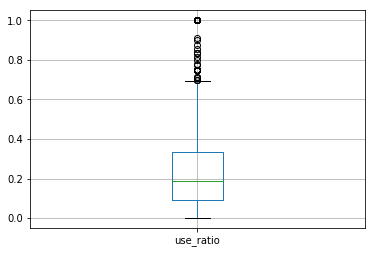

In [110]:
# 查看coupon平均被redeem的比例
coupon_cnt = train_received.groupby(['Coupon_id'])['User_id'].count().to_frame().reset_index()
redeem_cnt = train_received[train_received.label==1].groupby(['Coupon_id'])['User_id'].count().to_frame().reset_index()
t1 = coupon_cnt.merge(redeem_cnt, left_on='Coupon_id', right_on='Coupon_id')
t1[['User_id_y']] = t1[['User_id_y']].fillna(0)
t1['use_ratio'] = t1['User_id_y'] / t1['User_id_x']
t1[['use_ratio']].boxplot()

In [113]:
def getDiscountType(row):
    if row == 'null':
        return 'null'
    elif ':' in row:
        return 1
    else:
        return 0

def convertRate(row):
    """Convert discount to rate"""
    if row == 'null':
        return 1.0
    elif ':' in row:
        rows = row.split(':')
        return 1.0 - float(rows[1])/float(rows[0])
    else:
        return float(row)

def getDiscountMan(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[0])
    else:
        return 0

def getDiscountJian(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[1])
    else:
        return 0

def processData(df):
    
    # convert discunt_rate
    df['discount_rate'] = df['Discount_rate'].astype('str').apply(convertRate)
    df['discount_man'] = df['Discount_rate'].astype('str').apply(getDiscountMan)
    df['discount_jian'] = df['Discount_rate'].astype('str').apply(getDiscountJian)
    df['discount_type'] = df['Discount_rate'].astype('str').apply(getDiscountType)
    
    # convert distance
    df.loc[df.Distance.isna(), "Distance"] = 99
    return df

train_received = processData(train_received)
test_received = processData(test_received)

D:\Anacoda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anacoda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anacoda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anacoda3\lib\sit

In [119]:
train_received.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,use_days,label,discount_rate,discount_man,discount_jian,discount_type
1,1439408,2632,8591.0,20:1,0.0,2016-02-17,NaT,-1.0,0,0.95,20,1,1
2,1439408,2632,1078.0,20:1,0.0,2016-03-19,NaT,-1.0,0,0.95,20,1,1
3,1832624,3381,7610.0,200:20,0.0,2016-04-29,NaT,-1.0,0,0.90,200,20,1
4,2029232,3381,11951.0,200:20,1.0,2016-01-29,NaT,-1.0,0,0.90,200,20,1
5,2223968,3381,9776.0,10:5,2.0,2016-01-29,NaT,-1.0,0,0.50,10,5,1


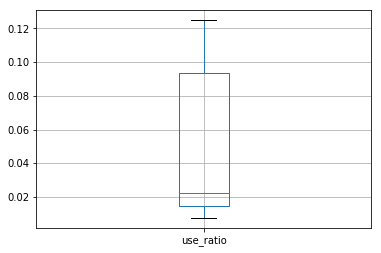

In [120]:
coupon_cnt = train_received.groupby(['discount_jian'])['User_id'].count().to_frame().reset_index()
redeem_cnt = train_received[train_received.label==1].groupby(['discount_jian'])['User_id'].count().to_frame().reset_index()
t1 = coupon_cnt.merge(redeem_cnt, left_on='discount_jian', right_on='discount_jian')
t1[['User_id_y']] = t1[['User_id_y']].fillna(0)
t1['use_ratio'] = t1['User_id_y'] / t1['User_id_x']
t1[['use_ratio']].boxplot()

In [121]:
t1

,discount_jian,User_id_x,User_id_y,use_ratio
0,0,27459,2903,0.105721
1,1,32412,4045,0.124799
2,5,278240,22635,0.081351
3,10,199749,4423,0.022143
4,20,117648,1565,0.013302
5,30,86224,647,0.007504
6,50,5228,86,0.016450
